# Single trial photometry analysis with timestamps
This script will analyze and save data from a single photometry trial (up to a few hours) combined with timestamps of events annotated from simultaneously acquired video or annotated in "real time". The photometry data is acquired from 2 channels: channel 1=neural recording (e.g. GCaMP); channel 2="control" channel (e.g. isosbestic) used to correct for movement artifacts.


The photometry file (acquired from pyPhotometry board) must be saved as a raw .ppd file, in its own directory with no other .ppd files. The photometry file name by default begins with the MouseID - this MouseID must begin with the letter 'A'.


If timestamps are to be incorporated, then this folder should also contain a .txt file containing a list of timestamps for events of interest. If the timestamps are video frames, the timestamp file should be named 'times_1.txt'. If the timestamps are in real time from the start of the photometry recording (minutes), the timestamp file should be called 'noVid_TS.txt'.
In either case, the timestamp file should have the following format:

FRAME,foodtype_EVENT; [followed by a line break before the next event]

OR

MINUTES,foodtype_EVENT; [followed by a line break before the next event]

`EVENT` can take different values:

    DROP - food is placed in cage

    CONTACT - mouse first contacts food

    BITE - mouse first bites food

    PAUSE - mouse stops eating

    RESUME - mouse resumes eating

If video was simultaneously acquired, the photometry file contains timestamps of TTL pulses aligned to the clock of the photometry board. These pulses are produced every time a video frame is acquired.

In [1]:
# Import libraries
import os
from os import listdir
from os.path import isfile, join
from functions.data_import import import_ppd #in "functions" folder
from tkinter.filedialog import askopenfilename
from tkinter import Tk
import numpy as np
import math
from statistics import mean
import matplotlib.pyplot as plt
from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize
import functions.find_all #in "functions" folder
import array
import csv
import pickle

############################################################
# Set these parameters to determine trial duration

F0PreTime=3 # mins before DROP to take as F0 (baseline period) - will exclude 15s before drop
PreTime=3 # mins before DROP to plot
PostTime=23 #mins after DROP to plot
############################################################

plt.rcParams['figure.figsize'] = [9,10.5] # Make default figure size larger.
plt.rcParams['axes.xmargin'] = 0          # Make default margin on x axis zero.

# Open a dialog box to select the photometry file to be analyzed
window = Tk()
window.wm_attributes('-topmost', 1)
window.withdraw()
PhotometryFile = askopenfilename(parent = window,
filetypes= (("ppd files","*.ppd"),("all files","*.*")))
# Import data from this file
data = import_ppd(PhotometryFile, None, None)

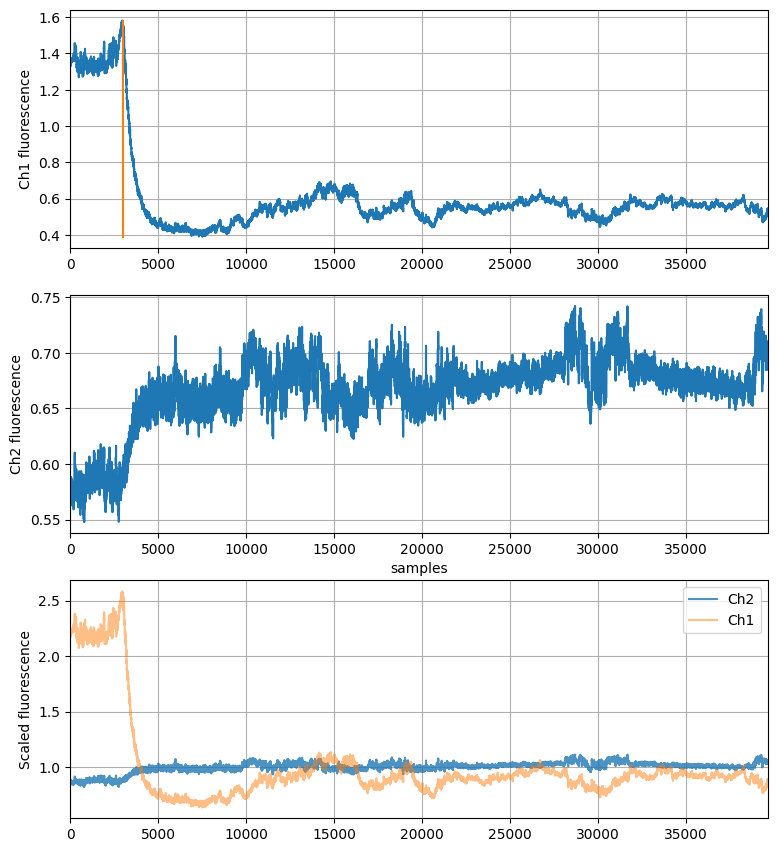

In [2]:
# Apply gaussian filter to each channel of photometry data to remove noise
sigma=data['sampling_rate']*0.1
width = math.ceil((6*sigma - 1)/2)
support = list(range(-width,width+1))
gaussFilter=[]
for i in support:
    gaussFilter.append(math.exp( (-i**2)/(2*(sigma**2)) ))

sumFilter=sum(gaussFilter)
for i in range(len(gaussFilter)):
    gaussFilter[i]=gaussFilter[i]/sumFilter

Ch1_Filt=np.convolve(data['analog_1'],gaussFilter,mode='valid')
Ch2_Filt=np.convolve(data['analog_2'],gaussFilter,mode='valid')

# Now take a first look at the data: plot channels 1 and 2 on subplots
fig, axs = plt.subplots(3, 1)
axs[0].plot(range(len(Ch1_Filt)),Ch1_Filt,[data['sampling_rate']*60*5,data['sampling_rate']*60*5],[min(Ch1_Filt),max(Ch1_Filt)]) #the last part adds tick at 5 minutes
axs[0].set_ylabel('Ch1 fluorescence')
axs[0].grid(True)

axs[1].plot(range(len(Ch2_Filt)),Ch2_Filt)
axs[1].set_xlabel('samples')
axs[1].set_ylabel('Ch2 fluorescence')
axs[1].grid(True)

# And plot the two channels on the same axes by scaling each to its mean
Ch1_Scaled = Ch1_Filt/mean(Ch1_Filt)
Ch2_Scaled = Ch2_Filt/mean(Ch2_Filt)

axs[2].plot(range(len(Ch2_Filt)),Ch2_Scaled,alpha=0.8,label='Ch2')
axs[2].plot(range(len(Ch1_Filt)),Ch1_Scaled,alpha=0.5,label='Ch1')
axs[2].set_ylabel('Scaled fluorescence')
axs[2].grid(True)
axs[2].legend(loc="upper right")

# Save this plot
Dir = PhotometryFile[0:PhotometryFile.rfind('A')]
os.chdir(Dir)
fig.savefig('filtered traces.png')


The recording from channel 2 is (largely) unaffected by neural activity, but contains any motion or bleaching artifacts that would be present in channel 1.
Therefore, we can use the channel 2 recording to predict the activity in channel 1 (using a linear regression model), and subtract this prediction from the actual channel 1 recording.
Any residual, unpredicted signals are likely non-artifactual, and thus due to neural activity.

One important note: there is a weak but significant negative correlation between channel 2 (isosbestic) signal and neural activity. Therefore, if the linear regression finds a negative coefficient, then there are no significant artifacts and we should not use this for correction. If the regression coefficient is positive, we will use this to predict the channel 1 activity and correct for artifacts as described above.

Slope    : -5.842
R-squared: 0.582


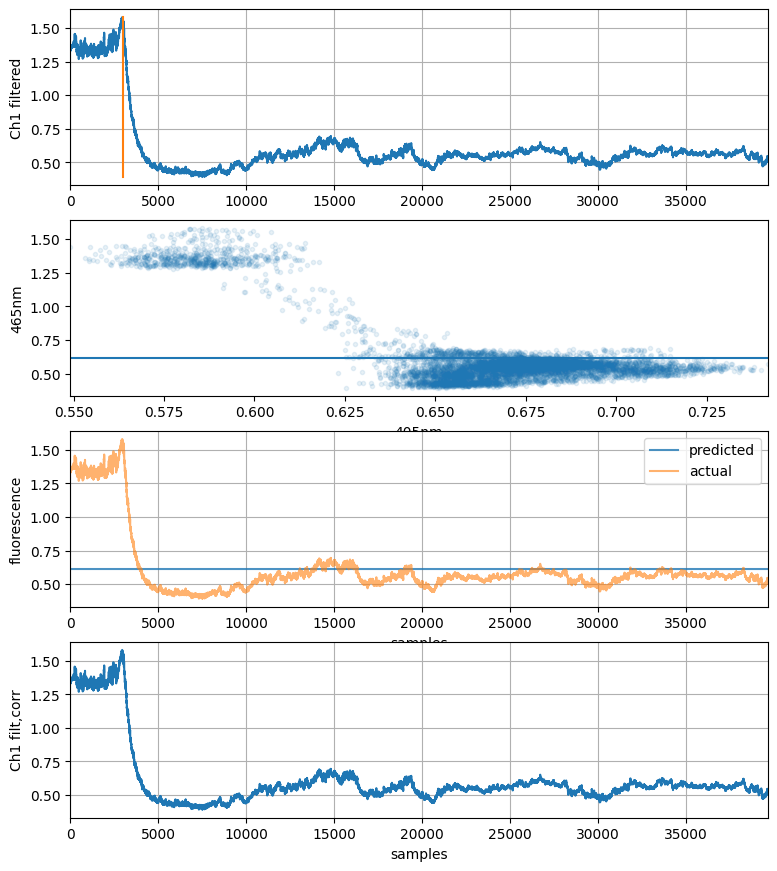

In [3]:
# Build linear regression model
slope, intercept, r_value, p_value, std_err = linregress(x=Ch2_Filt, y=Ch1_Filt)
# Print coefficient and R[2] values
print('Slope    : {:.3f}'.format(slope))
print('R-squared: {:.3f}'.format(r_value**2))

# Disregard the coefficient if it is negative
if slope < 0:
    slope = 0
    intercept = mean(Ch1_Filt)

# Calculate estimated motion component of GCaMP signal using this linear regression model
GCaMP_est_motion = intercept + (slope * Ch2_Filt)
GCaMP_est_mean = mean(GCaMP_est_motion)
GCaMP_corrected = Ch1_Filt - GCaMP_est_motion
GCaMP_corrected = GCaMP_corrected + GCaMP_est_mean

# Plot channel 1 signal before correction
fig, axs = plt.subplots(4, 1)
axs[0].plot(range(len(Ch1_Filt)),Ch1_Filt,[data['sampling_rate']*60*5,data['sampling_rate']*60*5],[min(Ch1_Filt),max(Ch1_Filt)]) #the last part adds tick at 5 minutes
axs[0].set_ylabel('Ch1 filtered')
axs[0].grid(True)

# Scatter plot of channel 1 vs channel 2 activity at each time point
axs[1].scatter(Ch2_Filt[::5], Ch1_Filt[::5],alpha=0.1, marker='.')
# And regression line
x = np.array(axs[1].get_xlim())
axs[1].plot(x, intercept+slope*x)
axs[1].set_xlabel('405nm') # 405nm = wavelength of isosbestic ("control") excitation
axs[1].set_ylabel('465nm') # 465nm = wavelength of activity-dependent excitation

# Plot predicted activity vs actual signal on same axes
axs[2].plot(range(len(GCaMP_est_motion)),GCaMP_est_motion,alpha=0.8,label='predicted')
axs[2].plot(range(len(Ch1_Filt)),Ch1_Filt,alpha=0.6,label='actual')
axs[2].set_xlabel('samples')
axs[2].set_ylabel('fluorescence')
axs[2].grid(True)
axs[2].legend(loc="upper right")

# Plot corrected activity (actual - predicted)
axs[3].plot(range(len(GCaMP_corrected)),GCaMP_corrected)
axs[3].set_xlabel('samples')
axs[3].set_ylabel('Ch1 filt,corr')
axs[3].grid(True)

# Make sure we are still in the original directory
Dir=PhotometryFile[0:PhotometryFile.rfind('A')] # Photometry file name always begins with 'A' since the mouse ID begins with 'A'
os.chdir(Dir)
# Save figure
fig.savefig('correction.png')


Next, align events of interest to the neural recording.

In [4]:
# Intialize list for each possible type of event
DropTimes=[]
ContactTimes=[]
BiteTimes=[]
FinishTimes=[]
BoutStarts = []
BoutEnds = []

# Convert trial duration variables to samples
F0PreTime=F0PreTime*60*data['sampling_rate']
PreTime=PreTime*60*data['sampling_rate']
PostTime=PostTime*60*data['sampling_rate']

# Make sure we are still in the correct directory
Dir=PhotometryFile[0:PhotometryFile.rfind('A')]
os.chdir(Dir)

# List all files in directory
onlyfiles = [f for f in listdir(Dir) if isfile(join(Dir, f))]
# Find files containing 'times' OR 'noVid_TS'.
# If 'times' (ie. annotations from video frames), set vidTS=True. 
# If 'noVid_TS' (ie. annotations in real time), set vidTS=False.
# If there is more than one annotation file, only the first will be used.
timesFiles=[]
timesFilesInc=0
for i in onlyfiles:
    if i.find('times')>-1:
        timesFiles.append(i)
        vidTS = True
    elif i.find('noVid_TS')>-1:
        timesFiles.append(i)
        vidTS = False

# Only add event annotations if there is an annotation file
if len(timesFiles) > 0:
    f = open(Dir + timesFiles[0], 'r')
    # Go through each line of 'times' file
    thisFile = f.readlines()
    # Loop through lines in times file (=events)
    for event in thisFile:
        # Find the first ',' - the video frame number comes before the ','
        comind = event.find(',')
        # Extract the frame number
        thisTS = int(event[0:comind])
        # If annotated from video file, convert frame number to photometry sample number - subtraction to account for
        # frames lost due to filtering (subtract half of lost frames because half at beginning
        # and half at end)
        if vidTS == True:
            thisTS = data['pulse_inds_2'][thisTS] - int((len(data['analog_1'])-len(Ch1_Filt))/2)
        # Or, if annotated as minutes from start of recording, convert to photometry sample number using sampling rate.
        # Still need to subtract for frames lost due to filtering.
        if vidTS == False:
            thisTS = thisTS*60*data['sampling_rate']- int((len(data['analog_1'])-len(Ch1_Filt))/2)
        
        # Now add the event to the appropriate list of events
        if 'DROP' in event:
            # There is only one DROP per photometry file, so only need to save this one timestamp for DROP
            DropTimes = thisTS
            # If the event is DROP, we need to know what kind of food was placed in the cage. This comes after the ',' and before the '_'.
            undind = event.find('_')
            DropWhat = event[comind+1:undind]
            del(undind)
        elif 'CONTACT' in event:
            ContactTimes = thisTS
        elif 'BITE' in event:
            BiteTimes = thisTS
            BoutStarts.append(thisTS)
        elif 'PAUSE' in event:
            BoutEnds.append(thisTS)
        elif 'RESUME' in event:
            BoutStarts.append(thisTS)
        elif 'FINISH' in event:
            FinishTimes = thisTS
            BoutEnds.append(thisTS)
        del(comind,thisTS)

Next, scale data using dF/F0. F0 is calculated as the mean of activity within a specific period (specified above) before the food is added. dF/F0 is calculated for each timepoint F using (F-F0)/F0.

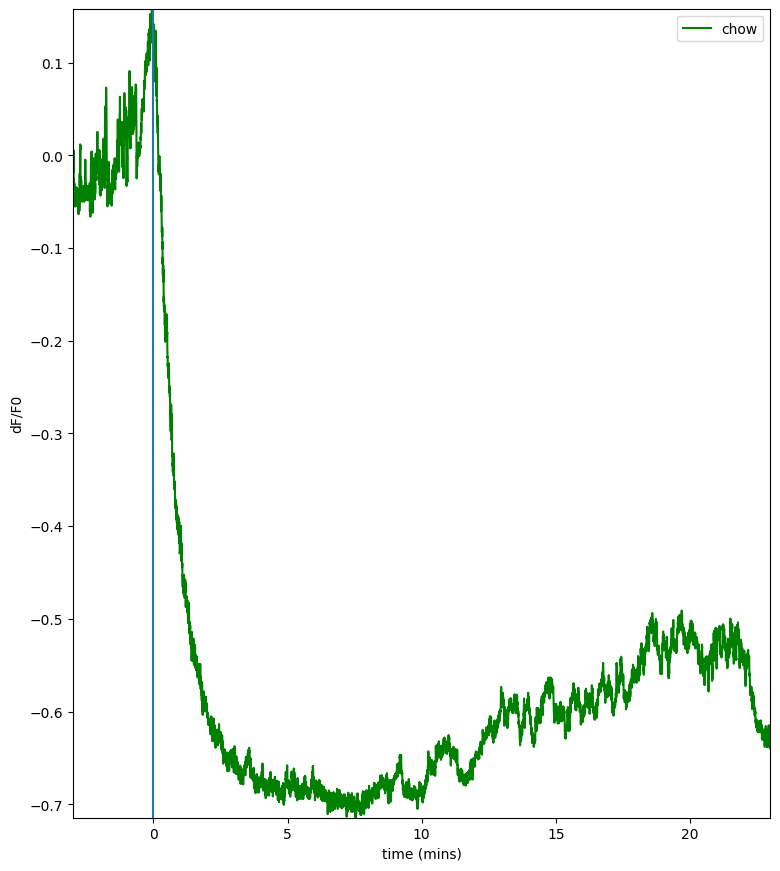

In [5]:
# Initialize 1d array to contain dF/F0
dFF0=np.zeros(shape=(PreTime+PostTime))
# Calculate F0 within the period before food is added
F0=mean(GCaMP_corrected[DropTimes-F0PreTime:DropTimes-10*data['sampling_rate']])
# Calculate dF/F0 for each timepoint
dFF0[:]=(GCaMP_corrected[DropTimes-PreTime:DropTimes+PostTime]-F0)/F0
del F0

# Now plot dF/F0
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot([x/(60*data['sampling_rate']) for x in range(-PreTime,PostTime)],dFF0,label=DropWhat,color='green')
ax.plot([0,0],[min(dFF0),max(dFF0)]) # plot a line at t=0
ax.set_ylim(min(dFF0),max(dFF0))

# Shade in feeding bouts
if len(BoutEnds)>0:
    for t in list(range(len(BoutStarts))):
        ax.fill([(BoutStarts[t]-DropTimes)/(60*data['sampling_rate']),(BoutStarts[t]-DropTimes)/(60*data['sampling_rate']),(BoutEnds[t]-DropTimes)/(60*data['sampling_rate']),(BoutEnds[t]-DropTimes)/(60*data['sampling_rate'])],[min(dFF0),max(dFF0),max(dFF0),min(dFF0)],"r",alpha=0.2) 

# Add labels to plot
ax.set_xlabel('time (mins)')
ax.set_ylabel('dF/F0')
ax.legend(loc="upper right")
fig.savefig('dFF0 DropAligned.png')
plt.show()

Finally, put all the data for this trial into a dictionary and save for downstream analysis.

In [6]:
# Make sure we're still in the correct directory
os.chdir(Dir)

# Put all data from this trial in a dictionary
DSrate = 10 # downsample to this rate (Hz)
# First create dict with keys containing arrays of correct size (for photometry data) and empty lists (for events)
ProcessedData = {'GCaMP_corrected' : GCaMP_corrected[list(range(0,len(GCaMP_corrected),int(data['sampling_rate']/DSrate)))], 
'Ch1_Filt' : Ch1_Filt[list(range(0,len(Ch1_Filt),int(data['sampling_rate']/DSrate)))], 
'Ch2_Filt' : Ch2_Filt[list(range(0,len(Ch2_Filt),int(data['sampling_rate']/DSrate)))], 
'DropTimes' : [], 'ContactTimes' : [], 'BiteTimes' : [], 'FinishTimes' : [], 'BoutStarts' : [], 'BoutEnds' : [], 'DropWhat' : DropWhat, 
'dFF0' : dFF0[list(range(0,len(dFF0),int(data['sampling_rate']/DSrate)))], 
'DSrate' : DSrate}

# List variables to be saved to dict
VarsToSave = [DropTimes, ContactTimes, BiteTimes, FinishTimes]
VarNames = ['DropTimes','ContactTimes','BiteTimes','FinishTimes']

# Loop through these variables and add to dict
for i in range(len(VarNames)):
    if VarsToSave[i] == []:
        ProcessedData[VarNames[i]] = []
    else:
        # Round timestamp to nearest sample given downsampling
        ProcessedData[VarNames[i]] = int(round(VarsToSave[i]/int(data['sampling_rate']/DSrate))) 

# Do 'BoutStarts' and 'BoutEnds' separately since each can contain multiple timestamps
if 'BoutStarts'== []:
    ProcessedData['BoutStarts'] = []
else:
    ProcessedData['BoutStarts'] = [int(round(n/int(data['sampling_rate']/DSrate))) for n in BoutStarts] 
if 'BoutEnds'== []:
    ProcessedData['BoutEnds'] = []
else:
    ProcessedData['BoutEnds'] = [int(round(n/int(data['sampling_rate']/DSrate))) for n in BoutEnds] 

del(VarsToSave,VarNames)

# Export dictionary as pickle file
f = open('Data_' + PhotometryFile[PhotometryFile.rfind('A'):PhotometryFile.rfind('.')] + '.pkl',"wb")
pickle.dump(ProcessedData,f)
f.close()